# TOMATO DISEASE PREDICTION

## Importing libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

## Data Preprocessing

### Data Augmentation

In [2]:
# Applying various transformations to the training data to increase its variability
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [3]:
# Rescaling validation data without augmentation
validation_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# Loading training data with data augmentation
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 21043 images belonging to 10 classes.


In [5]:
# Loading validation data
validation_generator = validation_datagen.flow_from_directory(
    'valid',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 5460 images belonging to 10 classes.


## Building the Model

### Transfer Learning with VGG16

In [6]:
# Using a pre-trained VGG16 model, excluding its top layers
base_model = VGG16(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

2024-07-29 01:14:11.707350: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-07-29 01:14:11.707391: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-29 01:14:11.707400: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-29 01:14:11.707423: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-29 01:14:11.707440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Freezing the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Adding custom top layers for our specific classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

In [9]:
# Defining the complete model
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
# Compiling the model with appropriate loss function and optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Training the Model

### Callbacks

In [11]:
# Setting up callbacks for early stopping, model checkpointing, and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

In [13]:
# Training the model with the specified configuration
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[early_stopping, model_checkpoint, reduce_lr]
    )

Epoch 1/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 118s 179ms/step - accuracy: 0.5051 - loss: 1.4808 - val_accuracy: 0.6786 - val_loss: 0.9074 - learning_rate: 0.0010
Epoch 2/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 120s 181ms/step - accuracy: 0.6839 - loss: 0.9394 - val_accuracy: 0.7271 - val_loss: 0.7789 - learning_rate: 0.0010
Epoch 3/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 120s 182ms/step - accuracy: 0.7031 - loss: 0.8660 - val_accuracy: 0.7480 - val_loss: 0.7084 - learning_rate: 0.0010
Epoch 4/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 120s 182ms/step - accuracy: 0.7299 - loss: 0.7733 - val_accuracy: 0.7874 - val_loss: 0.6197 - learning_rate: 0.0010
Epoch 5/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 122s 185ms/step - accuracy: 0.7429 - loss: 0.7433 - val_accuracy: 0.7841 - val_loss: 0.6333 - learning_rate: 0.0010
Epoch 6/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 119s 180ms/step - accuracy: 0.7532 - loss: 0.7212 - val_accuracy: 0.7824 - val_loss: 0.6242 - learning_rate: 0.0010
Epoch 7/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 120s 181ms/step - accura

## Visualizing Training History

In [14]:
# Plotting training and validation accuracy and loss
plt.figure(figsize=(12, 4))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

Text(0.5, 1.0, 'Accuracy')

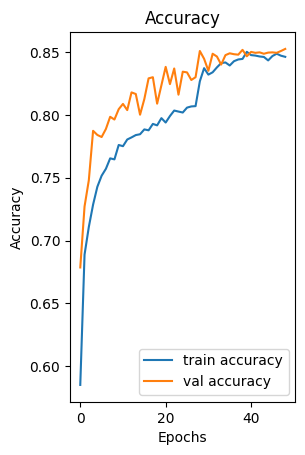

In [15]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

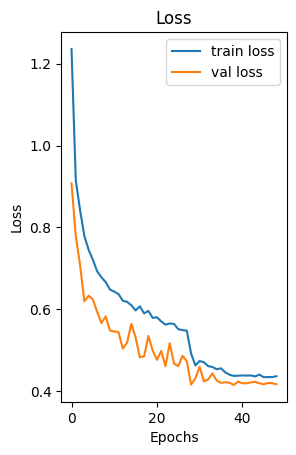

In [16]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

In [17]:
plt.show()

## Evaluating the Model

In [21]:
# Evaluating the trained model on the validation dataset
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {accuracy * 100:.2f}%")

171/171 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.8497 - loss: 0.4260
Validation accuracy: 85.18%


## Saving History

In [27]:
history.history #Return Dictionary of history

{'accuracy': [0.5850401520729065,
  0.6887801289558411,
  0.7107827067375183,
  0.7286033630371094,
  0.7428123354911804,
  0.7516038417816162,
  0.7571163773536682,
  0.7654326558113098,
  0.764624834060669,
  0.7760775685310364,
  0.775127112865448,
  0.7804495692253113,
  0.7821128368377686,
  0.7839661836624146,
  0.7846314907073975,
  0.7884807586669922,
  0.7877678871154785,
  0.7928527593612671,
  0.79171222448349,
  0.7974623441696167,
  0.7939457297325134,
  0.799125611782074,
  0.8034976124763489,
  0.8026897311210632,
  0.8019293546676636,
  0.8058261871337891,
  0.8067765831947327,
  0.8070142269134521,
  0.8267832398414612,
  0.8372380137443542,
  0.8321056962013245,
  0.8339590430259705,
  0.8378558158874512,
  0.8412773609161377,
  0.8418001532554626,
  0.8393765091896057,
  0.8427980542182922,
  0.8441762328147888,
  0.8446038961410522,
  0.850259006023407,
  0.8476452827453613,
  0.8472651243209839,
  0.846552312374115,
  0.8461720943450928,
  0.8434158563613892,
  0.8

In [28]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(history.history,f)